In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

classification_data = pd.read_csv('Model/mushrooms.csv')
regression_data = pd.read_csv('Model/VGChartzGamesSalesDataset.csv')


**1 - Optimal variable selection**

- Correlation matrix for the classification dataset

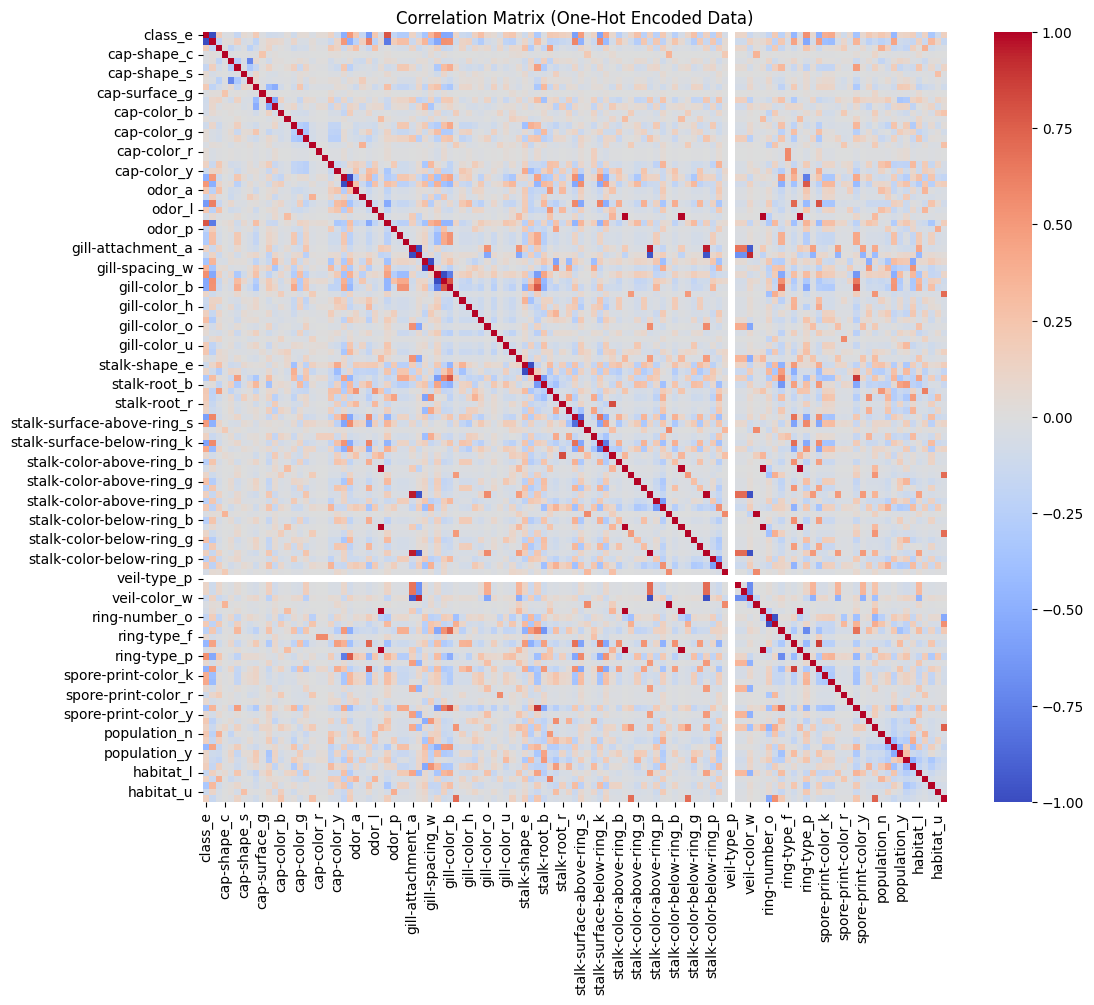

In [11]:
classification_data_encoded = pd.get_dummies(classification_data)
correlation_matrix = classification_data_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (One-Hot Encoded Data)')
plt.show()

- SelectKBest

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(classification_data['class'])

X_encoded = pd.get_dummies(classification_data.drop('class', axis=1), drop_first=True)

selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X_encoded, y)

selected_features = X_encoded.columns[selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: Index(['odor_f', 'odor_n', 'stalk-surface-above-ring_k',
       'stalk-surface-below-ring_k', 'ring-type_p'],
      dtype='object')


***2 - Deep Feature Synthesis***


In [13]:
import featuretools as ft

available_primitives = ft.primitives.list_primitives()
print(available_primitives)

available_transform_primitives = available_primitives[available_primitives['type'] == 'transform']
print(available_transform_primitives)

classification_data['index'] = range(len(classification_data))
es = ft.EntitySet(id="dataset")

es = es.add_dataframe(
    dataframe_name="data",
    dataframe=classification_data,
    index="index"
)

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="data",
    agg_primitives=["mean", "sum"],
    trans_primitives=["add_numeric", "divide_numeric"]
)

print(feature_matrix.head())

                             name         type  \
0                    percent_true  aggregation   
1    num_consecutive_greater_mean  aggregation   
2            max_consecutive_true  aggregation   
3           max_consecutive_zeros  aggregation   
4              count_greater_than  aggregation   
..                            ...          ...   
198  greater_than_equal_to_scalar    transform   
199                modulo_numeric    transform   
200                 rolling_trend    transform   
201                   geomidpoint    transform   
202                    is_weekend    transform   

                                           description  \
0             Determines the percent of `True` values.   
1    Determines the length of the longest subsequen...   
2    Determines the maximum number of consecutive T...   
3    Determines the maximum number of consecutive z...   
4    Determines the number of values greater than a...   
..                                                 

g:\1-Finlande\Data Analytics\Exercises\.venv\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
g:\1-Finlande\Data Analytics\Exercises\.venv\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
g:\1-Finlande\Data Analytics\Exercises\.venv\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
g:\1-Finlande\Data Analytics\Exercises\.venv\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could

      class cap-shape cap-surface cap-color  bruises odor gill-attachment  \
index                                                                       
0         p         x           s         n     True    p               f   
1         e         x           s         y     True    a               f   
2         e         b           s         w     True    l               f   
3         p         x           y         w     True    p               f   
4         e         x           s         g    False    n               f   

      gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
index                                    ...                            
0                c         n          k  ...                        s   
1                c         b          k  ...                        s   
2                c         b          n  ...                        s   
3                c         n          n  ...                        s   
4                w    

g:\1-Finlande\Data Analytics\Exercises\.venv\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
g:\1-Finlande\Data Analytics\Exercises\.venv\lib\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['add_numeric', 'divide_numeric']
  agg_primitives: ['mean', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


***3 - Redudancy management and dimensionnality reduction***

In [14]:
threshold = 0.9
high_corr = correlation_matrix[correlation_matrix > threshold]
high_corr_pairs = [(col, idx) for col in correlation_matrix.columns for idx in correlation_matrix.index if col != idx and correlation_matrix.loc[idx, col] > threshold]
print("Highly Correlated Features:", high_corr_pairs)

Highly Correlated Features: [('odor_m', 'stalk-color-above-ring_c'), ('odor_m', 'stalk-color-below-ring_c'), ('odor_m', 'ring-number_n'), ('odor_m', 'ring-type_n'), ('gill-attachment_a', 'stalk-color-above-ring_o'), ('gill-attachment_a', 'stalk-color-below-ring_o'), ('gill-attachment_f', 'veil-color_w'), ('stalk-color-above-ring_c', 'odor_m'), ('stalk-color-above-ring_c', 'stalk-color-below-ring_c'), ('stalk-color-above-ring_c', 'ring-number_n'), ('stalk-color-above-ring_c', 'ring-type_n'), ('stalk-color-above-ring_o', 'gill-attachment_a'), ('stalk-color-above-ring_o', 'stalk-color-below-ring_o'), ('stalk-color-above-ring_y', 'veil-color_y'), ('stalk-color-below-ring_c', 'odor_m'), ('stalk-color-below-ring_c', 'stalk-color-above-ring_c'), ('stalk-color-below-ring_c', 'ring-number_n'), ('stalk-color-below-ring_c', 'ring-type_n'), ('stalk-color-below-ring_o', 'gill-attachment_a'), ('stalk-color-below-ring_o', 'stalk-color-above-ring_o'), ('veil-color_w', 'gill-attachment_f'), ('veil-colo

Explained Variance Ratio: [0.09437127 0.07230109 0.0600148  0.05696235 0.05025506 0.04583798
 0.03548853 0.03340076 0.02556908 0.02300916 0.0220914  0.02058387
 0.01998826 0.0164684  0.01597799 0.01446103 0.01387055 0.01371623
 0.0128988  0.01269265 0.01243641 0.01188057 0.01163843 0.01148427
 0.0113296  0.01097357 0.01070427 0.01065944 0.01058888 0.01054709
 0.00996303 0.00980315 0.00967998 0.00937814 0.00911035 0.00893845
 0.00868681 0.00862876 0.00842333 0.00790545 0.00760776 0.00754142
 0.00720575 0.00686183 0.00662857 0.00656934 0.00627282 0.00620426
 0.00570946 0.00549483 0.00532047 0.00526438 0.00522197 0.00501323
 0.00482426]
Number of Components Selected: 55


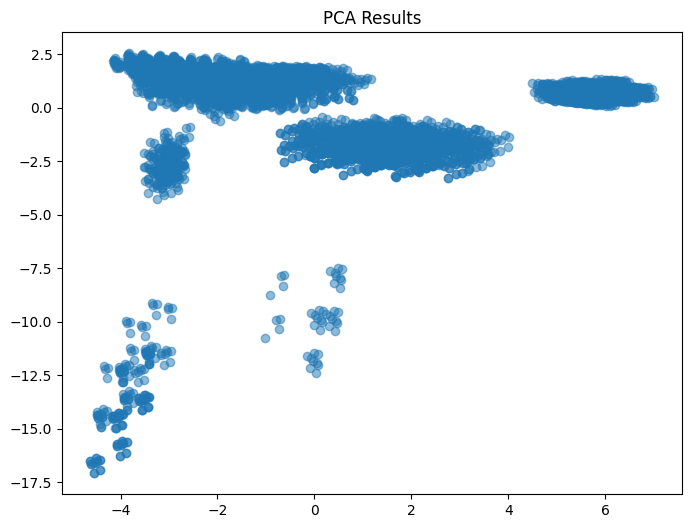

Original Dataset Shape: (8124, 95)
PCA-Reduced Dataset Shape: (8124, 55)
Variance Explained by PCA: 0.9544596101353429


In [15]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_encoded)

pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)
print("Number of Components Selected:", len(explained_variance_ratio))
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5)
plt.title('PCA Results')
plt.show()
print("Original Dataset Shape:", X_encoded.shape)
print("PCA-Reduced Dataset Shape:", data_pca.shape)
print("Variance Explained by PCA:", sum(explained_variance_ratio))

Correlation Analysis:
- Identifies and removes redundant features.

PCA:
- Reduces the dataset to essential dimensions while retaining most of the variance.

Evaluation:
- Ensures the reduced dataset retains its interpretability and usefulness.

***Step 2: Re-analyze***

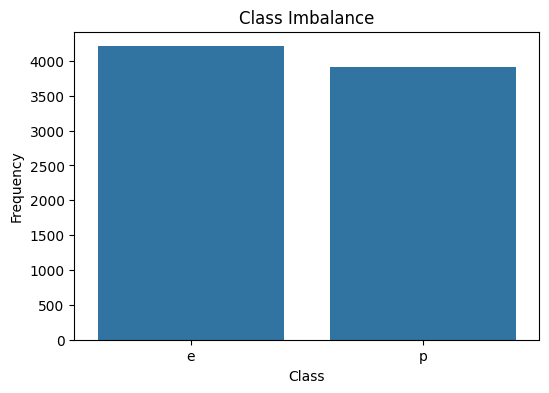

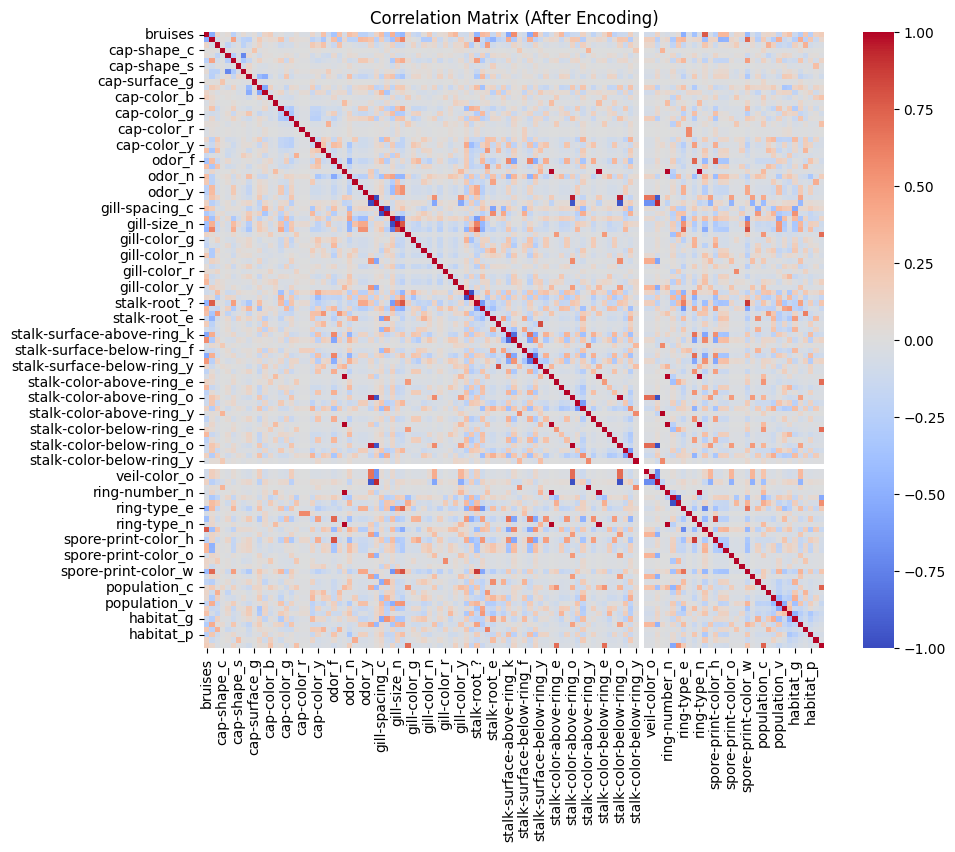

In [ ]:
class_counts = classification_data['class'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Imbalance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

encoded_classification_data = pd.get_dummies(classification_data.drop('class', axis=1))
correlation_matrix = encoded_classification_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (After Encoding)')
plt.show()
